# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

# Data

In [3]:
df = pd.read_csv('data/logs_all.csv')

In [4]:
info = ["Name"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [5]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

In [6]:
last_names = df["Name"].unique()

In [7]:
df

,Name,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Miguel-Almiron,83.0,0.0,3.0,0.0,0.2,0.2,0.0,0.0,0.0,2.0
1,Miguel-Almiron,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,Miguel-Almiron,69.0,0.0,3.0,0.0,0.2,0.2,0.1,1.0,1.0,3.0
3,Miguel-Almiron,88.0,0.0,2.0,1.0,0.2,0.2,0.1,0.0,1.0,2.0
4,Miguel-Almiron,90.0,2.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
100,Wilfried-Zaha,90.0,1.0,4.0,2.0,0.3,0.3,0.1,0.0,0.0,10.0
101,Wilfried-Zaha,90.0,0.0,2.0,0.0,0.9,0.1,0.1,0.0,0.0,2.0
102,Wilfried-Zaha,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
103,Wilfried-Zaha,90.0,0.0,1.0,0.0,0.1,0.1,0.6,1.0,0.0,3.0


In [8]:
for p in df["Name"].unique():
    print (p, df[df["Name"] == p].shape)

Miguel-Almiron (15, 11)
Kevin-De-Bruyne (15, 11)
Bruno-Fernandes (15, 11)
Mason-Mount (15, 11)
Bukayo-Saka (15, 11)
Mohamed-Salah (15, 11)
Wilfried-Zaha (15, 11)


In [9]:
# shifting
# df['FPL'] = df['FPL'].shift(-1)
# test_row = df[-1]
# df = df[:-1]

# DF to DataLoader

In [10]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        # print(idx)
        name = self.names[idx]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name].drop(columns=["Name"]).values[:, :-1]
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[-1, -1])
        # print(type(target))
        return features, target

In [11]:
dataset = PandasDataset(df)
dataset.__getitem__(3)

(array([[90. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.1,  0. ,  1. ],
        [76. ,  0. ,  3. ,  1. ,  0.3,  0.3,  0.3,  0. ,  0. ],
        [45. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.3,  0. ,  0. ],
        [31. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [83. ,  0. ,  3. ,  0. ,  0.2,  0.2,  0.1,  0. ,  0. ],
        [71. ,  0. ,  3. ,  0. ,  0.1,  0.1,  0.5,  1. ,  1. ],
        [90. ,  2. ,  3. ,  2. ,  0.4,  0.4,  0. ,  1. ,  0. ],
        [61. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  1. ],
        [90. ,  0. ,  3. ,  2. ,  0.1,  0.1,  0. ,  0. ,  0. ],
        [77. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0.1,  0. ,  1. ],
        [72. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [90. ,  1. ,  2. ,  2. ,  0.1,  0.1,  0.3,  1. ,  1. ],
        [72. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ]],
       dtype=float32),
 2.0)

In [12]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [13]:
torch.flatten(next(iter(dataloader))[0]).shape

torch.Size([135])

# LSTM Model

In [14]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        # print(x.shape)
        out, _ = self.lstm(x)
        out = self.fc(out[-1])
        return out

In [15]:
net = LSTMNetwork(9 * 15, 20, 2, 1, dropout=0.2)

# Training loop

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
num_epochs = 10000
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        # print(inputs.shape)
        # print(targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    if epoch % 100 == 0:
        print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

Epoch 0 Loss: 9.975805180413383
Epoch 100 Loss: 1.4085560307971068
Epoch 200 Loss: 1.21439722409871
Epoch 300 Loss: 0.5940864044906837
Epoch 400 Loss: 1.7240036928227969
Epoch 500 Loss: 0.04364801570773125
Epoch 600 Loss: 0.2078789723704436
Epoch 700 Loss: 0.24999981187283993
Epoch 800 Loss: 1.7329769212561328
Epoch 900 Loss: 1.7175012836399088
Epoch 1000 Loss: 1.7515727389535252
Epoch 1100 Loss: 1.7173107102974297
Epoch 1200 Loss: 1.791128098646368
Epoch 1300 Loss: 1.7565036053835814
Epoch 1400 Loss: 1.7740191022499598
Epoch 1500 Loss: 1.7433272840142828
Epoch 1600 Loss: 1.8100845211218777
Epoch 1700 Loss: 1.7333125690929592
Epoch 1800 Loss: 1.760327510510771
Epoch 1900 Loss: 1.6434308535673543
Epoch 2000 Loss: 1.6822689552115793
Epoch 2100 Loss: 1.7212317448242433
Epoch 2200 Loss: 1.7534211000893265
Epoch 2300 Loss: 1.697232247538133
Epoch 2400 Loss: 1.7252456978395847
Epoch 2500 Loss: 1.726519612728485
Epoch 2600 Loss: 1.7551618515395344
Epoch 2700 Loss: 1.7780924710303745
Epoch 280

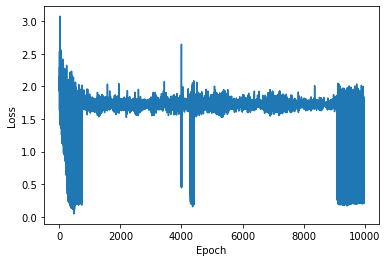

In [18]:
plt.plot(loss_history[25:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions

In [19]:
for name, (input, target) in zip (last_names, dataloader):
    output = net(input)
    print(name, round(output.item(), 2))

Miguel-Almiron 2.58
Kevin-De-Bruyne 2.58
Bruno-Fernandes 5.98
Mason-Mount 2.48
Bukayo-Saka 2.58
Mohamed-Salah 2.58
Wilfried-Zaha 2.64
